In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


2023-08-08 00:33:12.675725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 00:33:13.274236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/MonetGAN


2023-08-08 00:33:14.549711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 00:33:14.600494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 00:33:14.600875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Reading tfrecords

In [2]:
filpaths=[]
for root,dirs,files in os.walk(os.path.join(DATA_PATH, "monet_tfrec")):
    for f in files:
       filpaths.append(os.path.join(root,f))

In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [4]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [5]:
datasetMonet = load_dataset(filpaths, labeled=True)

2023-08-08 00:33:14.662917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 00:33:14.663487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 00:33:14.663973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 00:33:15.357945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 00:33:15.358353: I tensorflow/compile

## Larger dataset

In [6]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [7]:
def generator():
    for i,file in enumerate(allFiles):
        image = tf.io.read_file(file)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0, 0.1)
        image = (tf.cast(image, tf.float32) / 127.5) - 1
        yield image

In [8]:
g = generator()
test = next(g)
test.shape

TensorShape([256, 256, 3])

In [9]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32)))

## Tensorflow

In [10]:
%load_ext tensorboard


In [12]:
from tensorflow.keras import layers


def createGenerator():
    inputs = tf.keras.Input(shape=(1024,))
    # x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embedding")(inputs)

    x=tf.keras.layers.Dense(16*16*3)(inputs)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x=tf.keras.layers.Reshape((16,16,3))(x)

    x=tf.keras.layers.Conv2D(8, 5, padding="same")(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.BatchNormalization()(x)
    
    # x=layers.Conv2DTranspose(16, 5, strides=(2,2), padding="same")(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(16, 5, padding="same")(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x=tf.keras.layers.Conv2D(16, 5, padding="same")(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(32, 5, padding="same")(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x=tf.keras.layers.Conv2D(32, 5, padding="same")(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, 5, padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x=tf.keras.layers.Conv2D(64, 5, padding="same")(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, 5, padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x=tf.keras.layers.Conv2D(64, 5, padding="same")(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv2D(3, 5, padding="same")(x)
    outputs = tf.keras.activations.tanh(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="generator")

generator = createGenerator()

generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_1 (Dense)             (None, 768)               787200    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 768)               0         
                                                                 
 batch_normalization_9 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 8)         608       
                                                         

In [13]:

def createDiscriminator():
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    # x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embedding")(inputs)
    # x = layers.BatchNormalization()(tf.expand_dims(inputs,2))

    x = tf.keras.layers.Conv2D(8,5)(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(8,5)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16,5, strides=2)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16,5)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,5, strides=2)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,5)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,5, strides=2)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,5)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,5)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,5)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    outputs=layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="Discriminator")

discriminator = createDiscriminator()

discriminator.summary()


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 252, 252, 8)       0         
                                                                 
 batch_normalization_18 (Ba  (None, 252, 252, 8)       32        
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 248, 248, 8)       1608      
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 248, 248, 8)       0         
                                                     

In [14]:
def saveImages(model, epoch):
  testInput = tf.random.uniform((9, 1024))
  predictions = model(testInput, training=False)

  fig = plt.figure(figsize=(5, 5))

  for i in range(predictions.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.rint(predictions[i, :, :, :] * 127.5 + 127.5).astype(int))
    plt.axis('off')

  plt.savefig(os.path.join(DATA_PATH,"trainImages", 'epoch_{:04d}.png'.format(epoch)))


Start of epoch 1


2023-08-08 00:36:56.929136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-08 00:37:02.519955: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0035d38670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-08 00:37:02.519998: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-08-08 00:37:02.524921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-08 00:37:02.641414: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/Step 0, Loss Generator: 0.7399, Loss Discriminator: 1.7910, Accuracy Dis: 0.4688
Epoch 1/Step 5, Loss Generator: 0.6631, Loss Discriminator: 1.6366, Accuracy Dis: 0.5052
Epoch 1/Step 10, Loss Generator: 0.8104, Loss Discriminator: 1.4485, Accuracy Dis: 0.5298
Epoch 1/Step 15, Loss Generator: 0.7340, Loss Discriminator: 1.3591, Accuracy Dis: 0.5596
Epoch 1/Step 20, Loss Generator: 0.6384, Loss Discriminator: 1.4212, Accuracy Dis: 0.5766
Epoch 1/Step 25, Loss Generator: 0.7112, Loss Discriminator: 1.1864, Accuracy Dis: 0.5931
Epoch 1/Step 30, Loss Generator: 0.6848, Loss Discriminator: 1.3868, Accuracy Dis: 0.6053
Epoch 1/Step 35, Loss Generator: 0.6402, Loss Discriminator: 1.3999, Accuracy Dis: 0.6128
Epoch 1/Step 40, Loss Generator: 0.6716, Loss Discriminator: 1.3409, Accuracy Dis: 0.6181
Epoch 1/Step 45, Loss Generator: 0.7689, Loss Discriminator: 1.1773, Accuracy Dis: 0.6277
Epoch 1/Step 50, Loss Generator: 0.7297, Loss Discriminator: 1.1919, Accuracy Dis: 0.6342
Epoch 1/Step

2023-08-08 00:40:32.093263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 413 of 1000
2023-08-08 00:40:42.101732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 803 of 1000
2023-08-08 00:40:45.938173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 5/Step 0, Loss Generator: 1.3640, Loss Discriminator: 0.6189, Accuracy Dis: 1.0000
Epoch 5/Step 5, Loss Generator: 1.4280, Loss Discriminator: 0.6333, Accuracy Dis: 0.9635
Epoch 5/Step 10, Loss Generator: 1.5978, Loss Discriminator: 0.6117, Accuracy Dis: 0.9560
Epoch 5/Step 15, Loss Generator: 1.6332, Loss Discriminator: 0.6392, Accuracy Dis: 0.9502
Epoch 5/Step 20, Loss Generator: 1.4900, Loss Discriminator: 0.6134, Accuracy Dis: 0.9531
Epoch 5/Step 25, Loss Generator: 1.6163, Loss Discriminator: 0.6152, Accuracy Dis: 0.9507
Epoch 5/Step 30, Loss Generator: 1.4543, Loss Discriminator: 0.5966, Accuracy Dis: 0.9536
Epoch 5/Step 35, Loss Generator: 1.6182, Loss Discriminator: 0.5537, Accuracy Dis: 0.9557
Epoch 5/Step 40, Loss Generator: 1.3179, Loss Discriminator: 0.6568, Accuracy Dis: 0.9592
Epoch 5/Step 45, Loss Generator: 1.5371, Loss Discriminator: 0.5828, Accuracy Dis: 0.9623
Epoch 5/Step 50, Loss Generator: 1.5171, Loss Discriminator: 0.5943, Accuracy Dis: 0.9654
Epoch 5/Step

2023-08-08 00:44:26.215130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 773 of 1000
2023-08-08 00:44:29.077344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 7/Step 0, Loss Generator: 1.6358, Loss Discriminator: 0.4961, Accuracy Dis: 1.0000
Epoch 7/Step 5, Loss Generator: 1.5318, Loss Discriminator: 0.5156, Accuracy Dis: 0.9922
Epoch 7/Step 10, Loss Generator: 1.6153, Loss Discriminator: 0.4593, Accuracy Dis: 0.9929
Epoch 7/Step 15, Loss Generator: 1.4531, Loss Discriminator: 0.5019, Accuracy Dis: 0.9932
Epoch 7/Step 20, Loss Generator: 1.6487, Loss Discriminator: 0.5587, Accuracy Dis: 0.9911
Epoch 7/Step 25, Loss Generator: 1.4745, Loss Discriminator: 0.5255, Accuracy Dis: 0.9910
Epoch 7/Step 30, Loss Generator: 1.5181, Loss Discriminator: 0.4979, Accuracy Dis: 0.9904
Epoch 7/Step 35, Loss Generator: 1.5162, Loss Discriminator: 0.4777, Accuracy Dis: 0.9905
Epoch 7/Step 40, Loss Generator: 1.4458, Loss Discriminator: 0.5588, Accuracy Dis: 0.9889
Epoch 7/Step 45, Loss Generator: 1.6145, Loss Discriminator: 0.5116, Accuracy Dis: 0.9891
Epoch 7/Step 50, Loss Generator: 1.6271, Loss Discriminator: 0.4923, Accuracy Dis: 0.9850
Epoch 7/Step

2023-08-08 00:46:30.839861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 896 of 1000
2023-08-08 00:46:32.202298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 8/Step 0, Loss Generator: 1.7099, Loss Discriminator: 0.4490, Accuracy Dis: 0.9375
Epoch 8/Step 5, Loss Generator: 1.5067, Loss Discriminator: 0.4932, Accuracy Dis: 0.9714
Epoch 8/Step 10, Loss Generator: 1.6506, Loss Discriminator: 0.4684, Accuracy Dis: 0.9759
Epoch 8/Step 15, Loss Generator: 1.6582, Loss Discriminator: 0.4967, Accuracy Dis: 0.9668
Epoch 8/Step 20, Loss Generator: 1.9388, Loss Discriminator: 0.3649, Accuracy Dis: 0.9680
Epoch 8/Step 25, Loss Generator: 1.9427, Loss Discriminator: 0.3708, Accuracy Dis: 0.9712
Epoch 8/Step 30, Loss Generator: 1.9684, Loss Discriminator: 0.3729, Accuracy Dis: 0.9723
Epoch 8/Step 35, Loss Generator: 2.0163, Loss Discriminator: 0.3353, Accuracy Dis: 0.9740
Epoch 8/Step 40, Loss Generator: 1.9993, Loss Discriminator: 0.4095, Accuracy Dis: 0.9752
Epoch 8/Step 45, Loss Generator: 1.8756, Loss Discriminator: 0.3514, Accuracy Dis: 0.9769
Epoch 8/Step 50, Loss Generator: 1.8988, Loss Discriminator: 0.3816, Accuracy Dis: 0.9779
Epoch 8/Step

2023-08-08 00:47:49.680361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 824 of 1000
2023-08-08 00:47:52.279383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 9/Step 0, Loss Generator: 2.0052, Loss Discriminator: 0.3329, Accuracy Dis: 1.0000
Epoch 9/Step 5, Loss Generator: 2.0565, Loss Discriminator: 0.3499, Accuracy Dis: 0.9896
Epoch 9/Step 10, Loss Generator: 2.1738, Loss Discriminator: 0.4425, Accuracy Dis: 0.9915
Epoch 9/Step 15, Loss Generator: 2.0629, Loss Discriminator: 0.3740, Accuracy Dis: 0.9873
Epoch 9/Step 20, Loss Generator: 1.9944, Loss Discriminator: 0.3498, Accuracy Dis: 0.9888
Epoch 9/Step 25, Loss Generator: 2.2834, Loss Discriminator: 0.3355, Accuracy Dis: 0.9880
Epoch 9/Step 30, Loss Generator: 2.0232, Loss Discriminator: 0.3504, Accuracy Dis: 0.9889
Epoch 9/Step 35, Loss Generator: 1.8775, Loss Discriminator: 0.4632, Accuracy Dis: 0.9844
Epoch 9/Step 40, Loss Generator: 1.9649, Loss Discriminator: 0.4361, Accuracy Dis: 0.9783
Epoch 9/Step 45, Loss Generator: 1.7435, Loss Discriminator: 0.5206, Accuracy Dis: 0.9688
Epoch 9/Step 50, Loss Generator: 2.1065, Loss Discriminator: 0.4729, Accuracy Dis: 0.9651
Epoch 9/Step

2023-08-08 00:49:08.148672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 834 of 1000
2023-08-08 00:49:10.193622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 10/Step 0, Loss Generator: 2.0140, Loss Discriminator: 0.4683, Accuracy Dis: 0.9688
Epoch 10/Step 5, Loss Generator: 1.9524, Loss Discriminator: 0.5270, Accuracy Dis: 0.9609
Epoch 10/Step 10, Loss Generator: 1.8483, Loss Discriminator: 0.3059, Accuracy Dis: 0.9716
Epoch 10/Step 15, Loss Generator: 1.5971, Loss Discriminator: 0.4686, Accuracy Dis: 0.9717
Epoch 10/Step 20, Loss Generator: 1.9601, Loss Discriminator: 0.3512, Accuracy Dis: 0.9695
Epoch 10/Step 25, Loss Generator: 1.6035, Loss Discriminator: 0.4702, Accuracy Dis: 0.9675
Epoch 10/Step 30, Loss Generator: 1.8012, Loss Discriminator: 0.4047, Accuracy Dis: 0.9693
Epoch 10/Step 35, Loss Generator: 2.0491, Loss Discriminator: 0.4213, Accuracy Dis: 0.9727
Epoch 10/Step 40, Loss Generator: 1.7618, Loss Discriminator: 0.4094, Accuracy Dis: 0.9745
Epoch 10/Step 45, Loss Generator: 2.0687, Loss Discriminator: 0.4500, Accuracy Dis: 0.9725
Epoch 10/Step 50, Loss Generator: 1.9928, Loss Discriminator: 0.3677, Accuracy Dis: 0.9703
E

2023-08-08 00:50:27.301143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 879 of 1000
2023-08-08 00:50:28.823166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 11/Step 0, Loss Generator: 2.3164, Loss Discriminator: 0.2905, Accuracy Dis: 0.9844
Epoch 11/Step 5, Loss Generator: 2.3699, Loss Discriminator: 0.2530, Accuracy Dis: 0.9948
Epoch 11/Step 10, Loss Generator: 2.1785, Loss Discriminator: 0.2999, Accuracy Dis: 0.9943
Epoch 11/Step 15, Loss Generator: 1.8556, Loss Discriminator: 0.4017, Accuracy Dis: 0.9932
Epoch 11/Step 20, Loss Generator: 2.0172, Loss Discriminator: 0.3362, Accuracy Dis: 0.9888
Epoch 11/Step 25, Loss Generator: 1.6975, Loss Discriminator: 0.4410, Accuracy Dis: 0.9862
Epoch 11/Step 30, Loss Generator: 1.7150, Loss Discriminator: 0.3747, Accuracy Dis: 0.9859
Epoch 11/Step 35, Loss Generator: 1.9500, Loss Discriminator: 0.3142, Accuracy Dis: 0.9861
Epoch 11/Step 40, Loss Generator: 2.1008, Loss Discriminator: 0.4256, Accuracy Dis: 0.9848
Epoch 11/Step 45, Loss Generator: 1.9646, Loss Discriminator: 0.3213, Accuracy Dis: 0.9847
Epoch 11/Step 50, Loss Generator: 2.1735, Loss Discriminator: 0.3157, Accuracy Dis: 0.9853
E

2023-08-08 00:51:44.985985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 912 of 1000
2023-08-08 00:51:46.107192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 12/Step 0, Loss Generator: 2.1410, Loss Discriminator: 0.3178, Accuracy Dis: 1.0000
Epoch 12/Step 5, Loss Generator: 1.9148, Loss Discriminator: 0.3307, Accuracy Dis: 1.0000
Epoch 12/Step 10, Loss Generator: 1.9638, Loss Discriminator: 0.3210, Accuracy Dis: 0.9957
Epoch 12/Step 15, Loss Generator: 1.8750, Loss Discriminator: 0.2868, Accuracy Dis: 0.9951
Epoch 12/Step 20, Loss Generator: 2.0901, Loss Discriminator: 0.2506, Accuracy Dis: 0.9940
Epoch 12/Step 25, Loss Generator: 1.6935, Loss Discriminator: 0.3378, Accuracy Dis: 0.9946
Epoch 12/Step 30, Loss Generator: 2.0694, Loss Discriminator: 0.2468, Accuracy Dis: 0.9945
Epoch 12/Step 35, Loss Generator: 1.6998, Loss Discriminator: 0.3338, Accuracy Dis: 0.9944
Epoch 12/Step 40, Loss Generator: 1.8363, Loss Discriminator: 0.2979, Accuracy Dis: 0.9947
Epoch 12/Step 45, Loss Generator: 1.7876, Loss Discriminator: 0.2685, Accuracy Dis: 0.9939
Epoch 12/Step 50, Loss Generator: 1.6731, Loss Discriminator: 0.3314, Accuracy Dis: 0.9930
E

2023-08-08 00:53:04.897493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 899 of 1000
2023-08-08 00:53:06.325667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 13/Step 0, Loss Generator: 2.1085, Loss Discriminator: 0.2360, Accuracy Dis: 1.0000
Epoch 13/Step 5, Loss Generator: 2.1241, Loss Discriminator: 0.2394, Accuracy Dis: 0.9948
Epoch 13/Step 10, Loss Generator: 2.3680, Loss Discriminator: 0.2126, Accuracy Dis: 0.9957
Epoch 13/Step 15, Loss Generator: 2.1499, Loss Discriminator: 0.2479, Accuracy Dis: 0.9951
Epoch 13/Step 20, Loss Generator: 2.2431, Loss Discriminator: 0.2153, Accuracy Dis: 0.9940
Epoch 13/Step 25, Loss Generator: 2.2293, Loss Discriminator: 0.2131, Accuracy Dis: 0.9934
Epoch 13/Step 30, Loss Generator: 2.2544, Loss Discriminator: 0.2127, Accuracy Dis: 0.9940
Epoch 13/Step 35, Loss Generator: 1.9075, Loss Discriminator: 0.2889, Accuracy Dis: 0.9935
Epoch 13/Step 40, Loss Generator: 1.9364, Loss Discriminator: 0.2453, Accuracy Dis: 0.9943
Epoch 13/Step 45, Loss Generator: 2.0311, Loss Discriminator: 0.2148, Accuracy Dis: 0.9942
Epoch 13/Step 50, Loss Generator: 1.8262, Loss Discriminator: 0.2846, Accuracy Dis: 0.9936
E

2023-08-08 00:54:39.186255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 697 of 1000
2023-08-08 00:54:43.318237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 14/Step 0, Loss Generator: 2.0063, Loss Discriminator: 0.2484, Accuracy Dis: 1.0000
Epoch 14/Step 5, Loss Generator: 2.0583, Loss Discriminator: 0.2531, Accuracy Dis: 1.0000
Epoch 14/Step 10, Loss Generator: 1.9989, Loss Discriminator: 0.2620, Accuracy Dis: 0.9986
Epoch 14/Step 15, Loss Generator: 2.0700, Loss Discriminator: 0.2310, Accuracy Dis: 0.9980
Epoch 14/Step 20, Loss Generator: 2.0105, Loss Discriminator: 0.2295, Accuracy Dis: 0.9970
Epoch 14/Step 25, Loss Generator: 2.0806, Loss Discriminator: 0.2107, Accuracy Dis: 0.9970
Epoch 14/Step 30, Loss Generator: 2.0237, Loss Discriminator: 0.2316, Accuracy Dis: 0.9975
Epoch 14/Step 35, Loss Generator: 1.9875, Loss Discriminator: 0.3064, Accuracy Dis: 0.9965
Epoch 14/Step 40, Loss Generator: 1.7810, Loss Discriminator: 0.2886, Accuracy Dis: 0.9970
Epoch 14/Step 45, Loss Generator: 2.0999, Loss Discriminator: 0.2251, Accuracy Dis: 0.9969
Epoch 14/Step 50, Loss Generator: 1.7314, Loss Discriminator: 0.2504, Accuracy Dis: 0.9969
E

2023-08-08 00:56:22.273430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 824 of 1000
2023-08-08 00:56:24.616862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 15/Step 0, Loss Generator: 2.1057, Loss Discriminator: 0.2124, Accuracy Dis: 1.0000
Epoch 15/Step 5, Loss Generator: 1.7669, Loss Discriminator: 0.2788, Accuracy Dis: 0.9896
Epoch 15/Step 10, Loss Generator: 1.7198, Loss Discriminator: 0.2697, Accuracy Dis: 0.9943
Epoch 15/Step 15, Loss Generator: 1.7771, Loss Discriminator: 0.3212, Accuracy Dis: 0.9922
Epoch 15/Step 20, Loss Generator: 1.9365, Loss Discriminator: 0.2341, Accuracy Dis: 0.9940
Epoch 15/Step 25, Loss Generator: 2.0693, Loss Discriminator: 0.2230, Accuracy Dis: 0.9928
Epoch 15/Step 30, Loss Generator: 2.1437, Loss Discriminator: 0.1922, Accuracy Dis: 0.9919
Epoch 15/Step 35, Loss Generator: 1.9450, Loss Discriminator: 0.2587, Accuracy Dis: 0.9922
Epoch 15/Step 40, Loss Generator: 1.9333, Loss Discriminator: 0.3448, Accuracy Dis: 0.9912
Epoch 15/Step 45, Loss Generator: 1.8920, Loss Discriminator: 0.2624, Accuracy Dis: 0.9912
Epoch 15/Step 50, Loss Generator: 2.2286, Loss Discriminator: 0.2363, Accuracy Dis: 0.9911
E

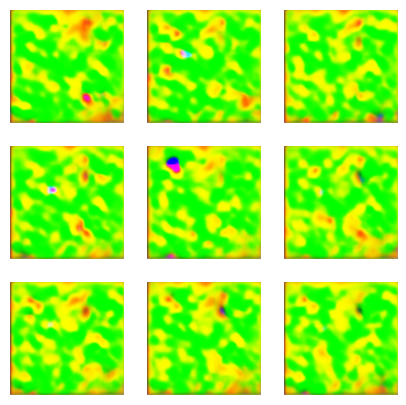

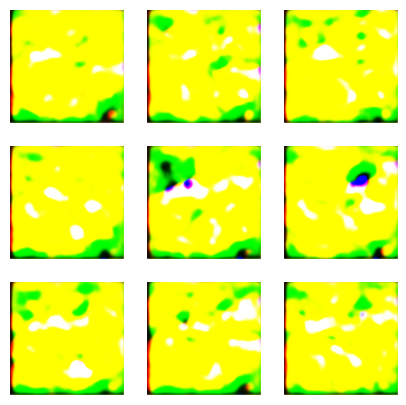

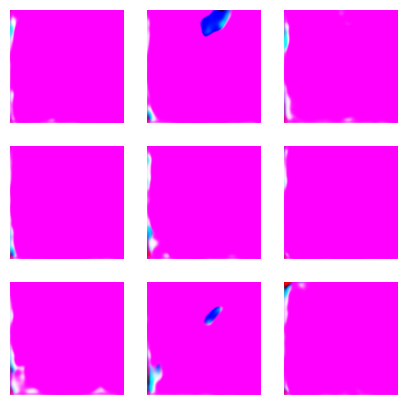

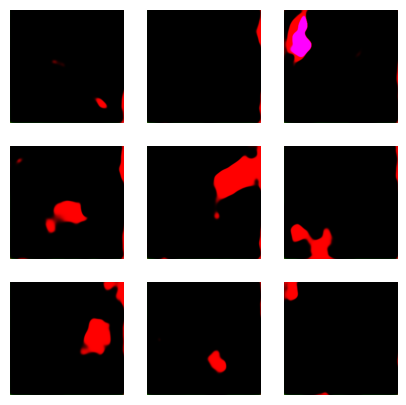

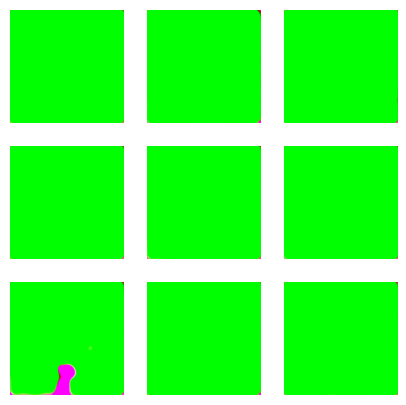

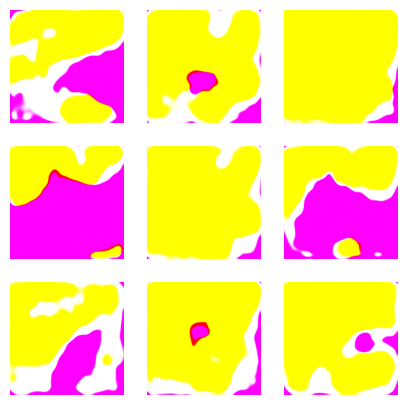

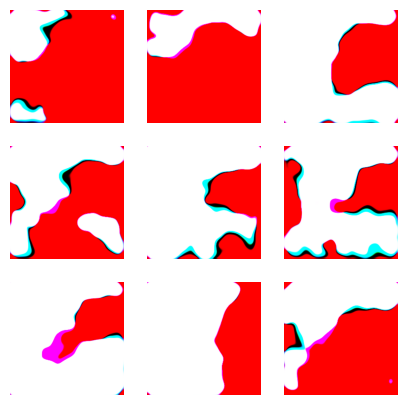

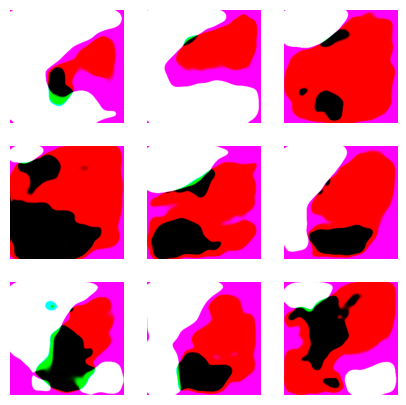

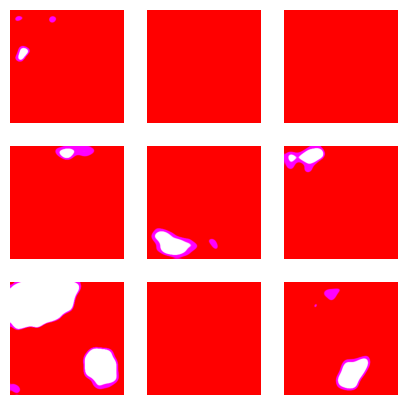

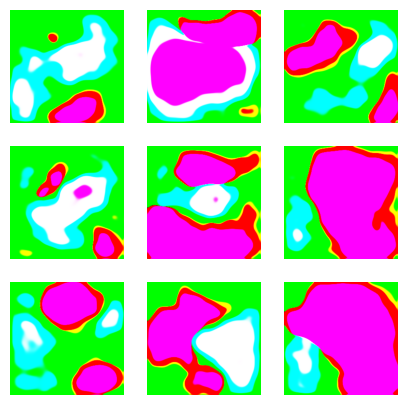

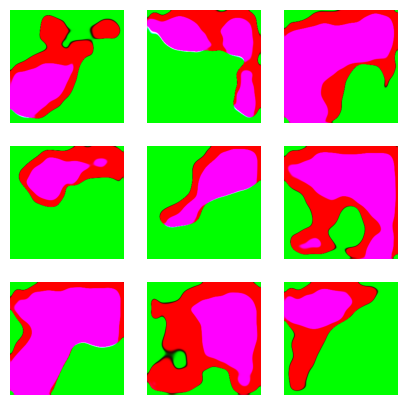

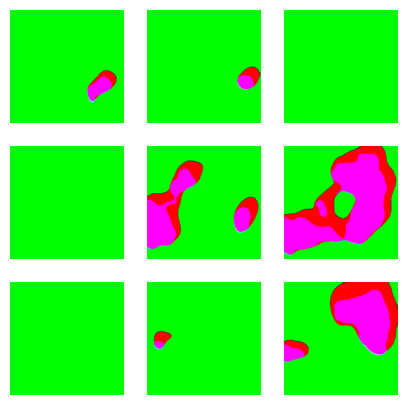

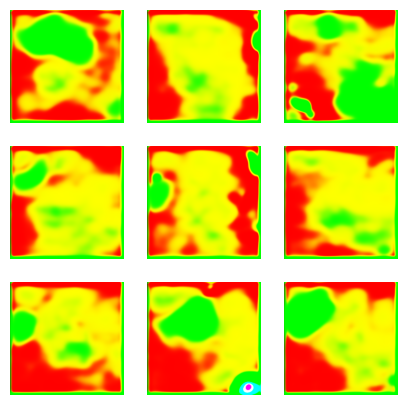

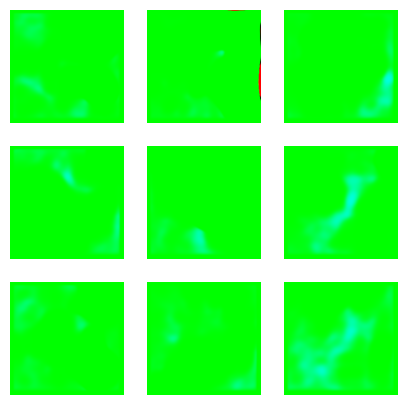

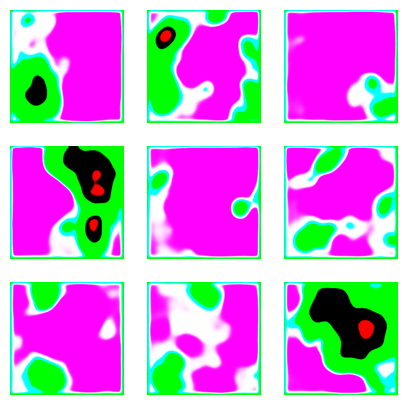

In [15]:

BATCH_SIZE=32
LOG_INTERVAL=5
epochs = 15
saveModel=False


log_dir = "./logs/"+generator.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizerGen = tf.keras.optimizers.Adam(learning_rate=1e-3)
optimizerDis = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Instantiate a loss function.
lossFnGen = tf.keras.losses.BinaryCrossentropy()
lossFnDis = tf.keras.losses.BinaryCrossentropy()

accuracyDis = tf.keras.metrics.BinaryAccuracy()

# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
dataset = dataset.shuffle(1000)
batchedDataset = dataset.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=False)

@tf.function()
def trainStepGen(trueImages, trainGen=True, trainDis=True):
    input = tf.random.uniform((BATCH_SIZE, 1024))
    with tf.GradientTape() as tapeGen, tf.GradientTape() as tapeDis:
        fakeImages = generator(input, training=True) 

        discOutputFake = discriminator(fakeImages, training=True)
        discOutputTrue = discriminator(trueImages, training=True)

        lossGen = lossFnGen(tf.ones_like(discOutputFake), discOutputFake)

        lossDisTrue = lossFnDis(tf.ones_like(discOutputTrue), discOutputTrue)
        lossDisFake = lossFnDis(tf.zeros_like(discOutputFake), discOutputFake)
        totalLossDis = lossDisTrue + lossDisFake

    gradsGen = tapeGen.gradient(lossGen, generator.trainable_weights)
    gradsDis = tapeDis.gradient(totalLossDis, discriminator.trainable_weights)

    accuracyDis.update_state(tf.zeros_like(discOutputFake), discOutputFake)
    accuracyDis.update_state(tf.ones_like(discOutputTrue), discOutputTrue)

    if trainGen:
        optimizerGen.apply_gradients(zip(gradsGen, generator.trainable_weights)) 
    if trainDis:
        optimizerDis.apply_gradients(zip(gradsDis, discriminator.trainable_weights)) 

    return lossGen, totalLossDis



maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(batchedDataset):

        if step%8==0:
            lossGen, lossDis = trainStepGen(x_batch_train, trainDis=True)
        else:
            lossGen, lossDis = trainStepGen(x_batch_train, trainDis=False)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss Generator: {:.4f}, Loss Discriminator: {:.4f}, Accuracy Dis: {:.4f}'
            print(template.format(epoch+1, step, lossGen.numpy(), lossDis.numpy(),  accuracyDis.result().numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('lossGen', lossGen, step=maxStep*epoch+step)
                tf.summary.scalar('lossDis', lossDis, step=maxStep*epoch+step)
                tf.summary.scalar('Disc Accuracy', accuracyDis.result().numpy(), step=maxStep*epoch+step)
                summary_writer.flush()

    maxStep=step

    accuracyDis.reset_state()

    print("Saving images")
    saveImages(generator, epoch)

    if saveModel:
      generator.save(os.path.join(DATA_PATH, "model_"+"_epoch_{}".format(epoch)))

In [ ]:
testInput = tf.random.uniform((9, 1024))
predictions = generator(testInput, training=False)

fig = plt.figure(figsize=(5, 5))

for i in range(predictions.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.rint(predictions[i, :, :, :] * 127.5 + 127.5).astype(int))
    plt.axis('off')

plt.show()